# Forward model using the Waveform Simulator

*Bart Pelssers, 27-03-2018*

Provides forward model for the ABC project using the Pax Waveform Simulator (Fax).


In [1]:
import numpy as np

In [2]:
np.warnings.filterwarnings('ignore')

In [3]:
from pax.core import Processor

In [4]:
class Model():
    """Implements the forward model for ABC project.
    
       The forward model used here uses the full pax waveformsimulation
       as input and the pax processing for output.
       
       Given a certain x,y position the model will first simulate an
       event using the waveformsimulator. Then reconstruct this event
       with the processor. It will then return the hit pattern of the
       main S2 of the event.
    """

    def __init__(self):
        # Setup pax using a custom configuration 'XENON1T_ABC.ini'
        self.pax = Processor(config_paths = ['XENON1T_ABC.ini'])
        # Get access to the input plugin WaveformSimulatorInput
        # derived from the WaveformSimulator class
        self.input_plugin = self.pax.get_plugin_by_name('WaveformSimulatorInput')
        # Use DummyOutput, it does not write to any file but
        # stores the event in its last_event variable
        self.output_plugin = self.pax.get_plugin_by_name('DummyOutput')
    
    def change_defaults(self, z = 0.0, t = 10000,
                        recoil_type = 'NR', s1_photons=50, s2_electrons = 25):
        # Set new default options
        # str() converts are necassary to work with WaveformSimulator
        new_defaults = {'g4_id': -1,
                        'x': 0.0,
                        'y': 0.0,
                        'z': str(z),
                        't': str(t),
                        'recoil_type': recoil_type,
                        's1_photons': str(s1_photons),
                        's2_electrons': str(s2_electrons),
                        }
        self.input_plugin.default_instruction = new_defaults.copy()

    def __call__(self, x, y):
        """Returns a hitpattern of s2_electrons
           for given x, y interaction position.
        """
        # Set new x,y position
        self.input_plugin.set_instruction_for_next_event(x, y)
        # Run the waveformsimulator and pax processor
        self.pax.run(clean_shutdown=False)
        # Return the top hit pattern of the main S2 of the processed event
        return self.output_plugin.last_event.main_s2.area_per_channel[:127]
    
    def get_latest_pax_position(self):
        # Return the reconstructed positions by pax for the last
        # processed event
        pos_rec = {}
        select_algorithm = ['PosRecNeuralNet', 'PosRecTopPatternFit']
        for rp in self.output_plugin.last_event.main_s2.reconstructed_positions:
            if rp.algorithm in select_algorithm:
                pos_rec[rp.algorithm] = {'x': rp.x,
                                         'y': rp.y}
        return pos_rec        

In [5]:
# Initialize the model
model = Model()

In [6]:
# OPTIONALLY: Set different defaults for z,t,recoil_type,s1_photons_s2_electrons
model.change_defaults(s2_electrons = 25)

In [7]:
# View the current defaults
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '50',
 's2_electrons': '25',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0.0'}

In [8]:
# Call the forward model with a certain x,y (and the other default settings)
model(10, 10)

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   3.27884646,   1.08414076,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   1.30481882,
         0.        ,   0.        ,   0.        ,   0.        ,
         1.37911152,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.89361876,   0.        ,   0.        ,   0.        ,
         1.07695009,   0.        ,   0.        ,   0.56714536,
         0.        ,   0.86025934,   0.        ,   0.        ,
         0.        ,   1.84326881,   1.23141354,   0.85487724,
         3.57821935,   2.31346253,   0.        ,   0.        ,
         0.        ,   3.36273945,   0.        ,   0.        ,
         0.        ,   0.        ,   1.5148566 ,   1.13574596,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   1.64235191,   0.        ,   0.  

In [9]:
# Get the position which pax reconstructed for this specific pattern
pos_dict = model.get_latest_pax_position()
pos_dict

{'PosRecNeuralNet': {'x': 10.359652189670213, 'y': 9.603516627296932},
 'PosRecTopPatternFit': {'x': 10.598370927318292, 'y': 9.600877192982452}}

# Tests

In [10]:
# Plot the pattern

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline

In [11]:
from pax.configuration import load_configuration

config = load_configuration('XENON1T')
pmt_config = config['DEFAULT']['pmts']
tpc_r = config['DEFAULT']['tpc_radius']
        
# PMT positions
xs_top = [pmt['position']['x'] for pmt in pmt_config][:127]
ys_top = [pmt['position']['y'] for pmt in pmt_config][:127]

def plot_hp(pat):
    plt.figure(figsize=(10,8))
    plt.scatter(xs_top, ys_top, c=pat, s=800, norm = LogNorm())
    plt.colorbar(label="Energy per PMT [pe]")
    plt.gca().set_aspect(1)
    plt.xlim(-tpc_r-5, tpc_r+5)
    plt.ylim(-tpc_r-5, tpc_r+5)
    plt.xlabel('x [cm]')
    plt.ylabel('y [cm]')

In [12]:
model.change_defaults(s1_photons = 500,
                      s2_electrons=25,
                      z = 0,
                      t = 10000)

In [13]:
model.input_plugin.default_instruction

{'g4_id': -1,
 'recoil_type': 'NR',
 's1_photons': '500',
 's2_electrons': '25',
 't': '10000',
 'x': 0.0,
 'y': 0.0,
 'z': '0'}

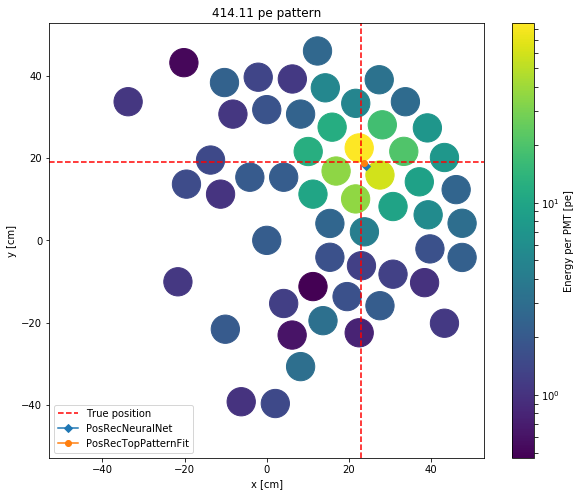

In [14]:
x, y = 23, 19
pat = model(x,y)

pos_dict = model.get_latest_pax_position()

plot_hp(pat)
# Add True position
plt.axhline(y, color='red', linestyle='--', label='True position')
plt.axvline(x, color='red', linestyle='--')
plt.title('%.2f pe pattern' % pat.sum())

# Add markers for the reconstructed pax position
for (marker, algo) in [('D', 'PosRecNeuralNet'), ('o', 'PosRecTopPatternFit')]:
    plt.plot(pos_dict[algo]['x'], pos_dict[algo]['y'], marker=marker, label=algo)

plt.legend(loc='lower left')
plt.show()

In [15]:
for swf in model.output_plugin.last_event.sum_waveforms:
    if swf.name == 'tpc_top':
        wf = swf.samples

In [16]:
ct = model.output_plugin.last_event.main_s2.center_time  # [ns]
ct /= 10  # [sample]

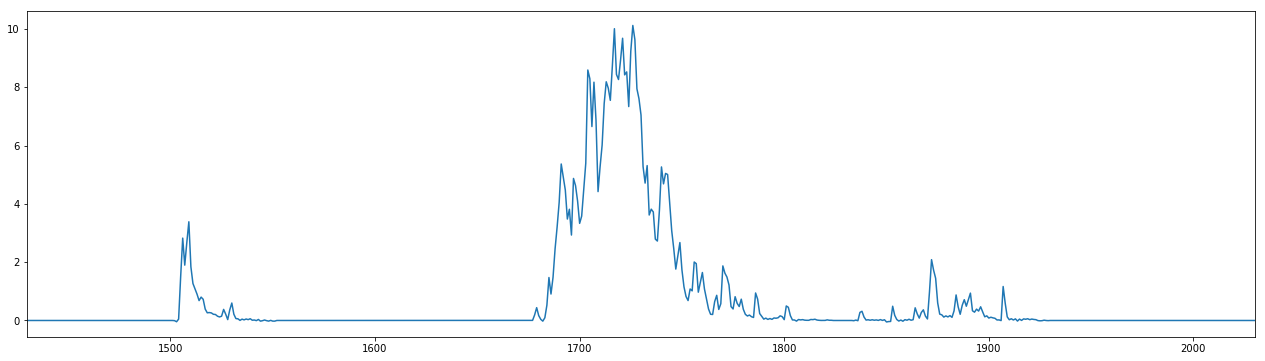

In [17]:
plt.figure(figsize=(22, 6))
plt.plot(wf)
plt.axvline(10000, color='red', linestyle='--')
plt.xlim(ct - 300, ct + 300)
plt.show()

## Speed

In [18]:
# The generation and reconstruction can be sped up by disabling more of pax' plugins,
# mainly pax' own position reconstruction. Of course that would require that we store
# the patterns somewhere and process them later with pax to get the pax reconstructed
# positions but then at least the ABC method will run faster.
# The speed also depends on the number of s1_photons and s2_electrons used.

from tqdm import tqdm
from pax.plugins.io.WaveformSimulator import uniform_circle_rv

patterns = [model(*uniform_circle_rv(tpc_r)) for _ in tqdm(range(100))]

100%|██████████| 100/100 [00:32<00:00,  2.93it/s]
